<a href="https://colab.research.google.com/github/Asura3301/makemore/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main reference papers:

["Kaiming init" paper | Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852)

[Batch Normalization paper | Sergey Ioffe](https://arxiv.org/pdf/1502.03167)

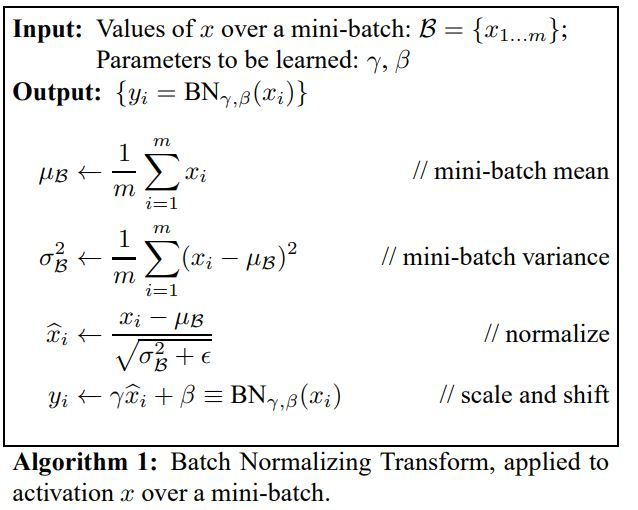

We use batch normalization to control the statistics of activations in nn. It is common to sprinkle batch norm layer across the nn and usually we will place it after layers that have multiplications e.g. linear layer, conv layer.

Batch norm internally has parameters for the **gain** and the **bias** and these trained using backpropagation, it also have two buffers: running **mean** and **standart deviation** these are trained not using backpropagation *janky*/not robust update

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("/content/drive/MyDrive/Colab Notebooks/Projects/makemore/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 # EOS/SOS
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset(train_test_split)
block_size = 3 # context length:how many characters we take to predict next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print("".join(itos[i] for i in context), "--->", itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xval, Yval = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP
n_embd = 10       # the dimensionality of the character embedding vectors
n_hidden = 200    # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # std = gain / fan_mode**0.5 | we have tanh func -> gain = 5/3
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] # b1
print(sum(p.nelement() for p in parameters)) # num of parameters in total

for p in parameters:
  p.requires_grad = True

12097


In [8]:
# approximate expected loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [9]:
# optimization step
max_steps = 200000
batch_size = 32
lossi = []
eps = 0.00001

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embedding of X
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 this bias dont impact the rest calculation (b1.grad=0), instead we have batch norm bias
  # Batch norm
  # ----------------------------
  bnmeani = hpreact.mean(0, keepdim=True)                           # calculating mean and std of activations that are feeding into batch norm layer
  bnstdi = hpreact.std(0, keepdim=True)                             # then its centering that batch to be unit Gaussian
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + eps) + bnbias  # and its offsetting and scaling it by learned bias and gain   | gain and bias are called "affine parameters"
  with torch.no_grad(): # 0.001 is "momentum"                       # and thats keeping track of the mean and std of the inputs
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani       # and its maintaining this running_mean and running_std
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi          # these will later used at inference, so we dont need to reestimate the mean and std all the time
  # -----------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # logits(output layer of nn)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    if p.grad is not None:
      p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3315


In [ ]:
# fixing saturated neurons problem
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of the training

# We are going to take a training set
# get pre-activ for every single training example
# and one single time estimate mean and std
# over entire training set
# and then we are going to get batch norm mean and std
# and now these are fixed numbers

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
# evaluation of optimization
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      "train": (Xtr, Ytr),
      "val": (Xval, Yval),
      "test": (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())

split_loss("train")
split_loss("val")

In [ ]:
# loss log

# original:
train 2.13
val  2.17

# fix softmax confidently wrong:
train  2.07
val  2.13

# fix tanh layer too saturated an initialization
train  2.038249969482422
val  2.1049816608428955

# using semi-principled "kaiming init" instead of hacky init
train  2.0387990474700928
val  2.1068685054779053

# add a batch norm layer
train 2.85774564743042
val 2.90346097946167

In [ ]:
# sample the model
g = torch.Generator().manual_seed(42)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize
  while True:
    # forward pass of nn
    emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample special "." eos/sos token, break
    if ix == 0:
      break

  print("".join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
# SUMMARY ---------------------

In [49]:
# train a deeper network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # fan_in norm helps us to avoid too high saturation of model
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running "momentum update")
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10       # the dimensionality of the character embedding vectors
n_hidden = 100    # the number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(42)

# initial embedding matrix
C = torch.randn((vocab_size, n_embd),             generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].weight *= 0.1 # because we used BatchNorm1d so we dont have to change weights, but instead we change gamma
  layers[-1].gamma *= 0.1
  # all other layers apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3   # gain value

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [50]:
# optimization step
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embedding of X
  x = emb.view(emb.shape[0], -1) # concat vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss func

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    # if p.grad is not None:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.2998


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.53%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.19%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.22%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.94%
layer 14 (      Tanh): mean +0.01, std 0.65, saturated: 1.72%


Text(0.5, 1.0, 'activation distribution')

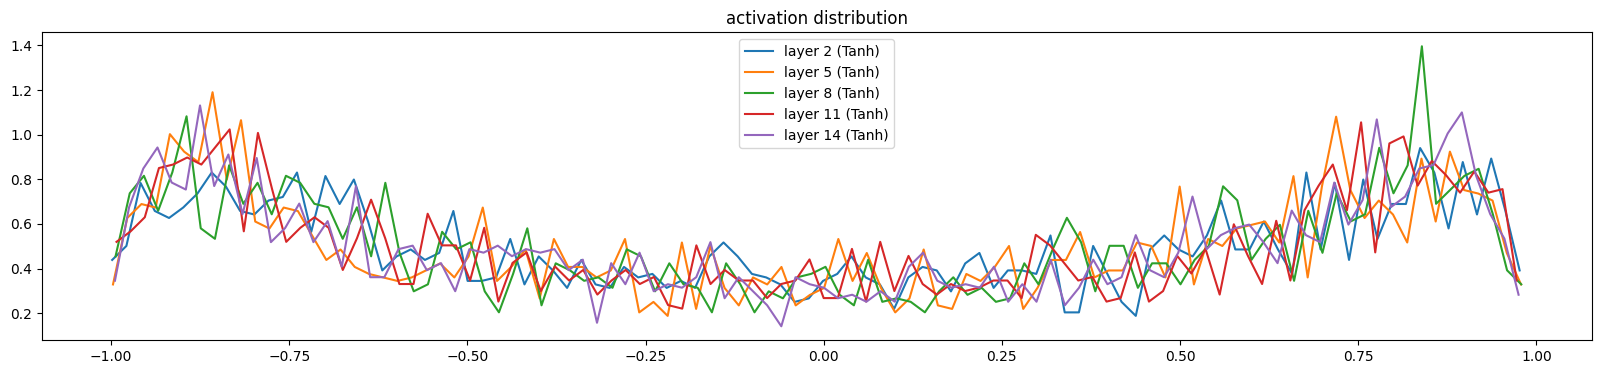

In [51]:
# visualize histograms of forward pass
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution")


layer 2 (      Tanh): mean -0.000000, std 3.047753e-03
layer 5 (      Tanh): mean +0.000000, std 2.560515e-03
layer 8 (      Tanh): mean +0.000000, std 2.490688e-03
layer 11 (      Tanh): mean -0.000000, std 2.356312e-03
layer 14 (      Tanh): mean -0.000000, std 2.374333e-03


Text(0.5, 1.0, 'gradient distribution')

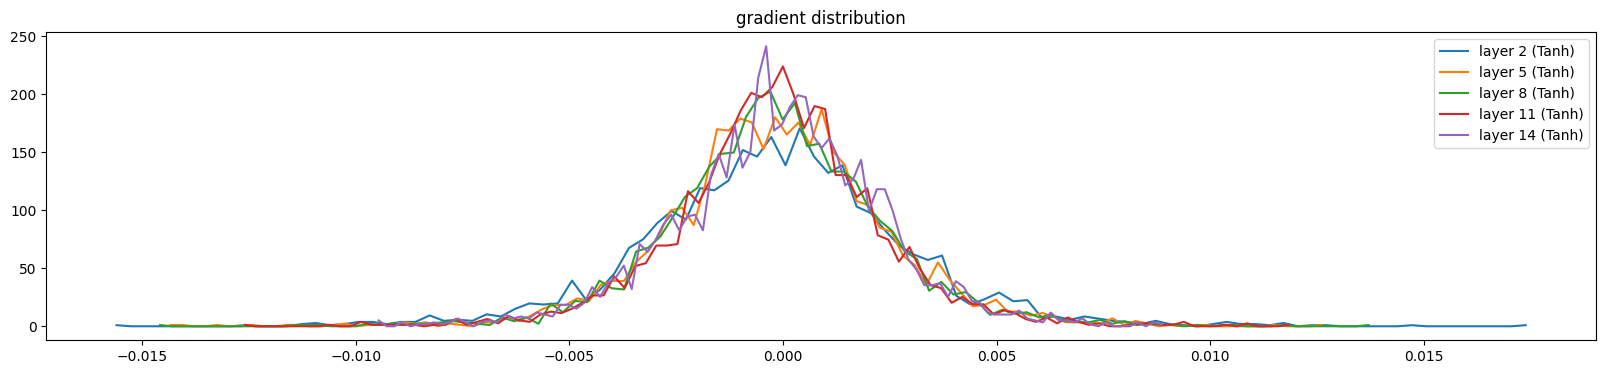

In [52]:
# visualize histograms of backward pass
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("gradient distribution")


weight   (27, 10) | mean -0.000000 | std 7.246053e-03 | grad:data ratio 7.238221e-03
weight  (30, 100) | mean -0.000177 | std 7.361281e-03 | grad:data ratio 2.415740e-02
weight (100, 100) | mean -0.000001 | std 6.638257e-03 | grad:data ratio 3.985054e-02
weight (100, 100) | mean +0.000055 | std 5.619071e-03 | grad:data ratio 3.355248e-02
weight (100, 100) | mean -0.000047 | std 5.112018e-03 | grad:data ratio 3.069071e-02
weight (100, 100) | mean -0.000028 | std 4.662754e-03 | grad:data ratio 2.745741e-02
weight  (100, 27) | mean +0.000011 | std 8.823094e-03 | grad:data ratio 5.254561e-02


Text(0.5, 1.0, 'weights gradient distribution')

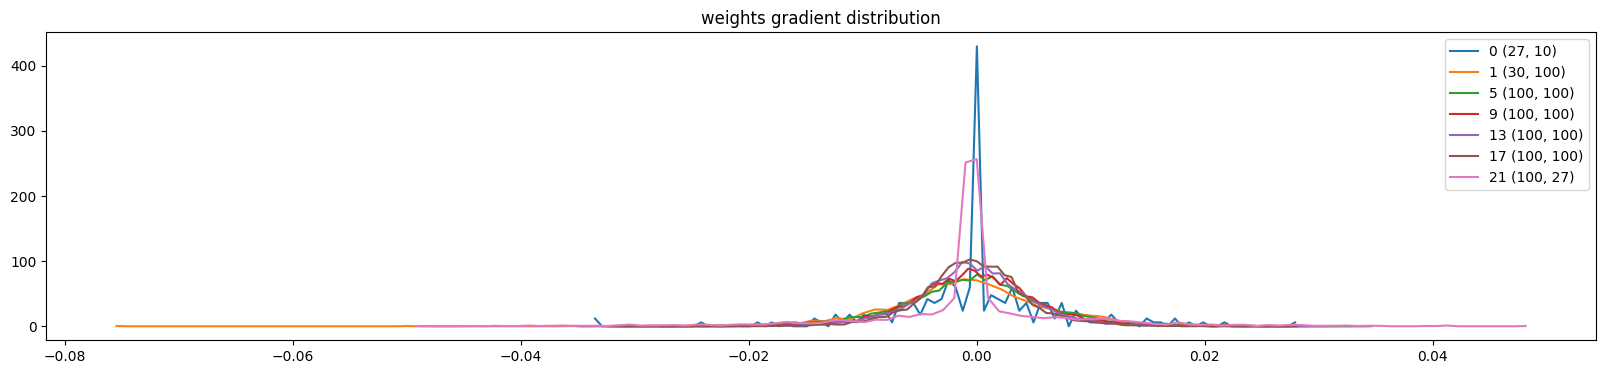

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print("weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends);
plt.title("weights gradient distribution")


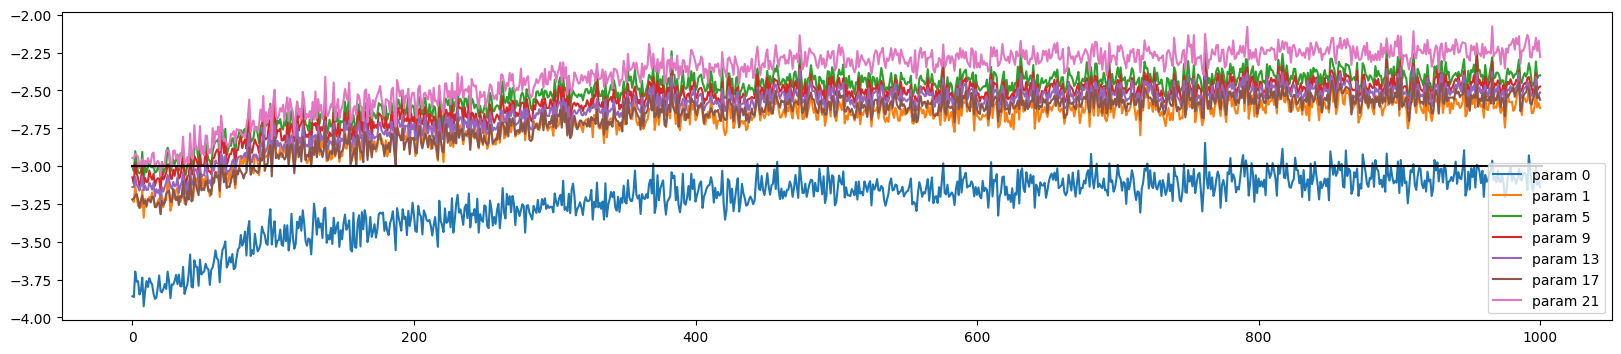

In [54]:
# plot histogram update data ratio over time, if its below threshold(1e-3) that means parameters no trained fast enough(means learning rate too low)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k") # these ratios should be ~1e-3, indicate on a plot
plt.legend(legends);